<center><h2>Assignment 2<center>

<div align = 'right' ><h5>Name = Shubham Narandekar</h5></div>
<div align = 'right' ><h5>Student Id = 20200132</h5></div>

In [110]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import string
from nltk.corpus import stopwords, wordnet
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
#Uncomment only when running for the first time to download
#nltk.download('wordnet')
#nltk.download('stopwords')

## Task 1 - Data Collection

In [2]:
html = urlopen('http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html')

In [3]:
page = BeautifulSoup(html,'html.parser')
page = page.find('div', class_='list-group')

In [4]:
#Getting the urls for the first page of each month
months = []
for a in page.find_all('a', href=True):
    months.append(a['href'])
months

['month-jan-001.html',
 'month-feb-001.html',
 'month-mar-001.html',
 'month-apr-001.html',
 'month-may-001.html',
 'month-jun-001.html',
 'month-jul-001.html',
 'month-aug-001.html',
 'month-sep-001.html',
 'month-oct-001.html',
 'month-nov-001.html',
 'month-dec-001.html']

The urls displayed above are for all the months. Each month has several pages in it. So I am defining a function that gathers url for each and every page of each months and return the list of urls.

In [5]:
def get_urls(months):
    urls = []
    for m in months:
        req = urlopen('http://mlg.ucd.ie/modules/COMP41680/assignment2/'+m)
        soup = BeautifulSoup(req, 'lxml')
        pages = soup.find('h4').text[-2:]
        for n in range(1,int(pages)+1):
            urls.append('http://mlg.ucd.ie/modules/COMP41680/assignment2/'+m[:-8]+ str(n).rjust(3,'0')+'.html')
    return urls

After getting the list of urls for every page of each month I am iterating thorugh the urls to get the list of articles present on that page.

In [7]:
def get_articles(urls):
    data1 = pd.DataFrame(columns=['Title','Snippet','Category'])
    articles = []
    for url in urls:
        req = urlopen(url)
        while req.status != 200:
            req = urlopen(url)
        soup = BeautifulSoup(req, 'html.parser')
        art = soup.find_all('div', class_='article')
        data1 = data(art,data1)
        print('Gathering data from :',url)
    return data1

From the list of articles of each page I am then collecting the data and storing it in a dataframe using the following function.

In [8]:
def data(articles, df):    
    for a in articles:
        title = a.find('h5')
        t = {'Title':title.find('a').text,
             'Snippet':a.find('p', attrs={'class':'snippet'}).text.replace('Summary: ',''),
             'Category':a.find_all('p', class_='metadata')[1].text.replace('Category: ','')}
        df = df.append(t,ignore_index=True)
    return df

In [9]:
urls = get_urls(months)
data = get_articles(urls)

Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-001.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-002.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-003.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-004.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-005.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-006.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-007.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-008.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-009.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-010.html
Gathering data from : http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-011.html
Gathering data from :

,Title,Snippet,Category
0,"Let's resolve to reconnect, says Welby in new ...",The archbishop of Canterbury will urge people ...,UK-News
1,Be honest. You're not going to read all those ...,"Every year, about this time, my Instagram feed...",Books
2,Mariah Carey's Twitter account hacked on New Y...,Mariah Carey’s Twitter account appeared to hav...,Music
3,The joy audit: how to have more fun in 2020,The last time I felt joy was at an event that ...,Life-and-Style
4,Providence Lost by Paul Lay review – the rise ...,The only public execution of a British head of...,Books
...,...,...,...
16221,Joe Biden to hold national memorial service fo...,Joe Biden plans to lead a unique nationwide me...,US-News
16222,Chess: Magnus Carlsen 'in a deep funk' after l...,Magnus Carlsen’s erratic form since his 30th b...,Sport
16223,Toby Flood leading Newcastle revival in Jonny ...,Amid the cluster of young English fly‑halves c...,Sport
16224,"MF Doom, iconic masked hip-hop MC, dies aged 49","MF Doom, one of US hip-hop’s most distinctive ...",Music


In the above output section we can see that I am collecting data from all the urls. The urls above are equivalent to the number of pages that each month section consists of.

In [10]:
data.Category.value_counts()

Books             1821
Sport             1819
Business          1817
US-News           1815
Politics          1808
Music             1797
UK-News           1795
Life-and-Style    1783
Film              1771
Name: Category, dtype: int64

Combining **'Ttile'** and **'Snippet'** of each **'Category'** into a single **'Document'** to create a corpus. Data pre-processing will be applied on the entire corpus of documents once combined.

In [11]:
data['Document'] = data['Title'] +' '+ data['Snippet']
data.drop(['Title','Snippet'],axis=1,inplace=True)
data = data.reindex(columns=['Document','Category'])
data

,Document,Category
0,"Let's resolve to reconnect, says Welby in new ...",UK-News
1,Be honest. You're not going to read all those ...,Books
2,Mariah Carey's Twitter account hacked on New Y...,Music
3,The joy audit: how to have more fun in 2020 Th...,Life-and-Style
4,Providence Lost by Paul Lay review – the rise ...,Books
...,...,...
16221,Joe Biden to hold national memorial service fo...,US-News
16222,Chess: Magnus Carlsen 'in a deep funk' after l...,Sport
16223,Toby Flood leading Newcastle revival in Jonny ...,Sport
16224,"MF Doom, iconic masked hip-hop MC, dies aged 4...",Music


The above dataframe consists of total 9 categories. From these 9 categories I am going to select three categories which I will use for multi-class classification and out of those three I will create pairs for binary classification.
<br> The ctegories I am selecting are:
1. **Books**
2. **Music**
3. **Sport**

In [139]:
data.to_csv('Task1_data.csv')
data = pd.read_csv('Task1_data.csv')
data.drop(data.columns[0], axis=1,inplace=True)
final = data[(data.Category == 'Sport') | (data.Category == 'Music') | (data.Category == 'Books')]
final

,Document,Category
1,Be honest. You're not going to read all those ...,Books
2,Mariah Carey's Twitter account hacked on New Y...,Music
4,Providence Lost by Paul Lay review – the rise ...,Books
9,'I'm on the hunt for humour and hope': what wi...,Books
10,Twenty athletes set to light up the Tokyo 2020...,Sport
...,...,...
16200,'All that mattered was survival': the songs th...,Music
16201,The most notable US athletes of 2020: No 1 – L...,Sport
16222,Chess: Magnus Carlsen 'in a deep funk' after l...,Sport
16223,Toby Flood leading Newcastle revival in Jonny ...,Sport


The **Documents** in the above dataframe consists of raw text. Before providing these documents to your model it is very neccessary to clean your data. Data cleaning is required because providing raw data to your model will restrict the model to train and predict in a robust manner. The model will unnecessarily learn noise from the raw data that is not required.

### Data pre-processing

In order to clean the data I am going to use the following data pre-processing techniques:
1. **Lower case**: It is a good practice to convert all the text into lower case because there might be words like 'Walking' and 'walking' which both means the same but the model will treat them differently.
2. **Removing punctuation**: The text may contain a lot of punctuations which are not required in classification and should be removed to reduce ambiguity. Python's string.punctuation gives us all the punctuations which we can be used to removed them from our text.
3. **Removing HTML tags**: As we have gathered the data from urls using web scraping, the documents may contain html tags which we need to remove.
4. **Removing stopwords**: There will be a lot of stop words like 'a', 'the', 'for', etc in the sentences and are most common words in sentences. Removing these words will help the model to focus only on important or key words. A list of stop words is provided by the **nltk** which can be used to remove them from our documents.
5. **Normalization**: It is a process of converting all the words to their root form. There are mainly two techniques for this:
 - Stemming: It usually cuts off the prefixes and suffixes of the words but this can not be useful all the time. For example it cuts the word from 'caring' to 'car' which completely changes its meaning.
 - Lemmatization: It usually performes normalization by using the morphological analysis of words and vocabulary. It's aim to remove inflectional endings and return dictionary or base form of the word. For example it will normalize the word from 'caring' to 'care' and also preserves the meaning of the word. I am going to use this technique for normalizng my documents. **WordNetLemmatizer** provided by **nltk** can be used.
6. **Tokenization**: It is a process of splitting the entire sentence into words which helps to easily interpret the meaning of the sentence. I am not performing tokenization in the data pre-processing section because further I am using TfidfVectorizer to convert the words into numbers. The TfidfVectorizer internally performes tokenization on the text passed to it.

In [140]:
def checkcount(data):
    data['Punctuations'] = data['Document'].apply(lambda length: len(" ".join(_ for _ in length if _ in string.punctuation)))
    data['Upper_case'] = data['Document'].apply(lambda word: len([_ for _ in str(word).split() if _.isupper()]))
    data['Title'] = data['Document'].apply(lambda word: len([_ for _ in str(word).split() if _.istitle()]))
    data['WordswNumbers'] = data['Document'].apply(lambda word: len(re.findall(r'\w*\d\w*', word)))
    data['SingleLetters'] = data['Document'].apply(lambda word: len(re.findall(r'\b[a-zA-Z]\b', word)))
    return data

First I will check the count of punctuations, uppercase words, titles and words with numbers in it from each document.

In [141]:
final = checkcount(final)
final

,Document,Category,Punctuations,Upper_case,Title,WordswNumbers,SingleLetters
1,Be honest. You're not going to read all those ...,Books,15,0,3,0,0
2,Mariah Carey's Twitter account hacked on New Y...,Music,7,0,7,2,4
4,Providence Lost by Paul Lay review – the rise ...,Books,1,0,13,3,3
9,'I'm on the hunt for humour and hope': what wi...,Books,15,2,5,1,5
10,Twenty athletes set to light up the Tokyo 2020...,Sport,13,0,12,4,1
...,...,...,...,...,...,...,...
16200,'All that mattered was survival': the songs th...,Music,7,0,6,1,1
16201,The most notable US athletes of 2020: No 1 – L...,Sport,5,2,8,2,4
16222,Chess: Magnus Carlsen 'in a deep funk' after l...,Sport,5,0,9,1,4
16223,Toby Flood leading Newcastle revival in Jonny ...,Sport,3,0,10,1,1


In [142]:
def clean(data):
    #Converting to lowercase
    data.loc[:,'Document'] = data['Document'].str.lower() 
    #Removing all the punctuations
    punctuations = string.punctuation
    data.loc[:,'Document'] = data['Document'].apply(lambda text: text.translate(str.maketrans('', '', punctuations)))
    #Removing HTML tags if any
    data.loc[:,'Document'] = data['Document'].apply(lambda text: re.sub(r'<.*?>', '', text).strip())
    #Removing all the stopwords
    stopword = stopwords.words('english')
    data.loc[:,'Document'] = data['Document'].apply(lambda text: " ".join([word for word in str(text).split() 
                                                                     if word not in stopword]))
    #Lemmatizing
    lemmat = WordNetLemmatizer()
    data.loc[:,'Document'] = data['Document'].apply(lambda text: " ".join([lemmat.lemmatize(word, wordnet.VERB) 
                                                                           for word in text.split()]))
    data.loc[:,'Document'] = data['Document'].apply(lambda text: " ".join([lemmat.lemmatize(word, wordnet.NOUN) 
                                                                           for word in text.split()]))
    data.loc[:,'Document'] = data['Document'].apply(lambda text: " ".join([lemmat.lemmatize(word, wordnet.ADJ) 
                                                                           for word in text.split()]))
    #Removing numbers and words that contains numbers in it
    data.loc[:,'Document'] = data['Document'].apply(lambda text: re.sub(r'\w*\d\w*', '', text).strip())
    #Removing words with single letter
    data.loc[:,'Document'] = data['Document'].apply(lambda text: re.sub(r'\b[a-zA-Z]\b', '', text).strip())
    return data

In [143]:
#Cleaning and pre-processing
final = clean(final)
final = checkcount(final)
final

,Document,Category,Punctuations,Upper_case,Title,WordswNumbers,SingleLetters
1,honest youre go read book holiday every year t...,Books,0,0,0,0,0
2,mariah careys twitter account hack new year ev...,Music,0,0,0,0,0
4,providence lose paul lay review – rise fall ol...,Books,0,0,0,0,0
9,im hunt humour hope author read matt haig dar...,Books,0,0,0,0,0
10,twenty athlete set light tokyo olympics dina ...,Sport,0,0,0,0,0
...,...,...,...,...,...,...,...
16200,matter survival song get isaac hay – go circ...,Music,0,0,0,0,0
16201,notable athlete – lebron jam man season las...,Sport,0,0,0,0,0
16222,chess magnus carlsen deep funk late defeat dan...,Sport,0,0,0,0,0
16223,toby flood lead newcastle revival jonny wilkin...,Sport,0,0,0,0,0


###### Counting frequant words in all the classes

In [144]:
books = Counter()
music = Counter()
sport = Counter()
for text in final[final.Category== 'Books']["Document"].values:
    for word in text.split():
        books[word] += 1
for text in final[final.Category== 'Music']["Document"].values:
    for word in text.split():
        music[word] += 1
for text in final[final.Category== 'Sport']["Document"].values:
    for word in text.split():
        sport[word] += 1
books.most_common(10)
music.most_common(10)
sport.most_common(10)
#Printing top10 frequent words all the three classes
print('Books =',books.most_common(15),'\n Music = ',music.most_common(15),'\n Sport = ',sport.most_common(15))

Books = [('…', 1835), ('–', 887), ('review', 704), ('book', 599), ('novel', 328), ('year', 213), ('read', 210), ('write', 197), ('author', 189), ('first', 181), ('new', 173), ('time', 162), ('one', 159), ('story', 157), ('writer', 154)] 
 Music =  [('…', 1810), ('–', 871), ('review', 554), ('music', 440), ('album', 273), ('die', 241), ('one', 225), ('age', 224), ('year', 223), ('new', 222), ('first', 168), ('make', 168), ('song', 161), ('pop', 154), ('time', 136)] 
 Sport =  [('…', 1827), ('england', 344), ('sport', 243), ('–', 242), ('one', 235), ('world', 227), ('say', 212), ('race', 204), ('rugby', 198), ('win', 191), ('year', 191), ('new', 185), ('test', 184), ('first', 183), ('day', 181)]


The words that most frequent and belongs to all the three categories should be removed because they will contribute in the same amount to all the classes which is not helpful for classification. I will remove these words as well.

In [145]:
words_to_remove = ['…','–','one','first','year','new']
final['Document'] = final['Document'].apply(lambda text: " ".join([word for word in str(text).split() 
                                                                   if word not in words_to_remove]))
final

,Document,Category,Punctuations,Upper_case,Title,WordswNumbers,SingleLetters
1,honest youre go read book holiday every time i...,Books,0,0,0,0,0
2,mariah careys twitter account hack eve mariah ...,Music,0,0,0,0,0
4,providence lose paul lay review rise fall oliv...,Books,0,0,0,0,0
9,im hunt humour hope author read matt haig dark...,Books,0,0,0,0,0
10,twenty athlete set light tokyo olympics dina a...,Sport,0,0,0,0,0
...,...,...,...,...,...,...,...
16200,matter survival song get isaac hay go circle c...,Music,0,0,0,0,0
16201,notable athlete lebron jam man season last mon...,Sport,0,0,0,0,0
16222,chess magnus carlsen deep funk late defeat dan...,Sport,0,0,0,0,0
16223,toby flood lead newcastle revival jonny wilkin...,Sport,0,0,0,0,0


In [146]:
final.to_csv('Cleaned.csv')

###### Making pairs for binary calssification

In [147]:
#Function to create dataframes with pairs for binary calssification
def pair(final,classes):
    binary = final[(final.Category == classes[0]) | (final.Category == classes[1])]
    return binary

In [148]:
binary1 = pair(final,['Sport','Books'])
binary2 = pair(final,['Sport','Music'])
binary3 = pair(final,['Music','Books'])
print('Pair 1: ')
print(binary1.Category.value_counts())
print('Pair 2: ')
print(binary2.Category.value_counts())
print('Pair 3: ')
print(binary3.Category.value_counts())

Pair 1: 
Books    1821
Sport    1819
Name: Category, dtype: int64
Pair 2: 
Sport    1819
Music    1797
Name: Category, dtype: int64
Pair 3: 
Books    1821
Music    1797
Name: Category, dtype: int64


From the above output we can see that for all the three pairs, there are almost similar number of records for each category. This tells us that the data is balanced. So further I am going to use Accuracy as my evaluation metric. If the data was imbalanced then I would have used ROC AUC as an evaluation metric.

Once the documents are cleaned, before providing them to the model we have to create numeric representation of the documents. The process of converting these words into numeric form is called vectorization. There are two common techniques which are used for vectorization:
1. **BagOfWords (BOW)**: A list of all the unique words that are present in the documents is created called vocabulary. Each document is then represented as vector where each word in that vector is represented by the number of times it appears in that document. It is know as the term frequency. The drawback of BOW is that it does not consider the rareness of the word.
2. **TF-IDF Vectorizer**: In this approach, each word is replace with the term frequencyinverse document freqeuncy. Some words may appear more frequently in all the documents and those words should be discounted so the inverse document frequency is used to make those words less valuable.
I am going to use **TF-IDF Vectorizer** and **BagOfWords (BOW)** for both binary classification and for multi-class classification

In [149]:
def vectorization(xtrain, xtest):
    #TFIDF Vectorization
    vect = TfidfVectorizer(analyzer='word')
    xtrain_tfidf = vect.fit_transform(xtrain)
    xtest_tfidf = vect.transform(xtest)
    
    #Count Vectorization
    cvect = CountVectorizer()
    xtrain_cv = cvect.fit_transform(xtrain)
    xtest_cv = cvect.transform(xtest)
    
    return xtrain_tfidf, xtest_tfidf, xtrain_cv, xtest_cv

In [150]:
#Fucntion train the models and predict the categories for unseen data.
def classify(model, xtrain, ytrain, xtest, ytest, classes):
    model.fit(xtrain, ytrain)
    tpred = model.predict(xtrain)
    pred = model.predict(xtest)
    print(model,' Training accuracy: ',metrics.accuracy_score(tpred, ytrain),
          ' Testing accuracy: ',metrics.accuracy_score(pred, ytest))
    #print('Testing accuracy: ',metrics.accuracy_score(pred, ytest))
    cm = metrics.confusion_matrix(pred, ytest)
    if len(classes) == 2:
        plt.subplots(figsize=(3,2))
        plt.title(model)
        sns.heatmap(cm, annot=True, fmt='.4g', xticklabels=[classes[0],classes[1]],
            yticklabels=[classes[0],classes[1]], cmap='Blues')
    else:
        plt.subplots(figsize=(3,2))
        plt.title(model)
        sns.heatmap(cm, annot=True, fmt='.4g', xticklabels=[classes[0],classes[1],classes[2]],
            yticklabels=[classes[0],classes[1],classes[2]], cmap='Blues',)

In [151]:
#Using Lbael encoding to ecode the target variable i.e. the categories
def encode(ytrain, ytest):
    encoder = preprocessing.LabelEncoder()
    ytrain = encoder.fit_transform(ytrain)
    ytest = encoder.transform(ytest)
    return ytrain, ytest, encoder.classes_

## Task 2 - Binary Classification

In [152]:
xtrain1, xtest1, ytrain1 , ytest1 = model_selection.train_test_split(binary1['Document'], binary1['Category'], test_size = 0.2,
                                                                    random_state=42)
xtrain2, xtest2, ytrain2 , ytest2 = model_selection.train_test_split(binary2['Document'], binary2['Category'], test_size = 0.2,
                                                                    random_state=42)
xtrain3, xtest3, ytrain3 , ytest3 = model_selection.train_test_split(binary3['Document'], binary3['Category'], test_size = 0.2,
                                                                    random_state=42)
print(' Train shape: ',xtrain1.shape)
print(' Test shape: ',xtest1.shape)
print(' Train shape: ',xtrain2.shape)
print(' Test shape: ',xtest2.shape)
print(' Train shape: ',xtrain3.shape)
print(' Test shape: ',xtest3.shape)

 Train shape:  (2912,)
 Test shape:  (728,)
 Train shape:  (2892,)
 Test shape:  (724,)
 Train shape:  (2894,)
 Test shape:  (724,)


In [153]:
#Vectorize all the three pairs using TfidfVectorizer and CountVectorizer
#Pair 1
xtrain_tfidf1, xtest_tfidf1, xtrain_cv1, xtest_cv1 = vectorization(xtrain1, xtest1) 
#Pair 2
xtrain_tfidf2, xtest_tfidf2, xtrain_cv2, xtest_cv2 = vectorization(xtrain2, xtest2)
#Pair 3
xtrain_tfidf3, xtest_tfidf3, xtrain_cv3, xtest_cv3 = vectorization(xtrain3, xtest3)

#Encode all the three pairs
#Pair 1
ytrain1, ytest1, classes1 = encode(ytrain1, ytest1)
#Pair 2
ytrain2, ytest2, classes2 = encode(ytrain2, ytest2)
#Pair 3
ytrain3, ytest3, classes3 = encode(ytrain3, ytest3)

### Pair 1: (Books, Sport)

###### Using TfidfVectorizer

LogisticRegression()  Training accuracy:  0.9945054945054945  Testing accuracy:  0.9807692307692307
MultinomialNB()  Training accuracy:  0.9945054945054945  Testing accuracy:  0.9739010989010989


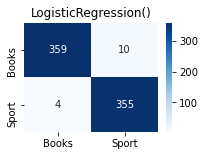

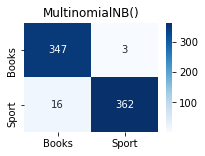

In [154]:
#Logistic Regression
lr = LogisticRegression()
#Naive Bayes
nb = MultinomialNB()
for model in [lr,nb]:
    classify(model, xtrain_tfidf1, ytrain1, xtest_tfidf1, ytest1, classes1)

###### Using CountVectorizer

LogisticRegression()  Training accuracy:  1.0  Testing accuracy:  0.9821428571428571
MultinomialNB()  Training accuracy:  0.9958791208791209  Testing accuracy:  0.9862637362637363


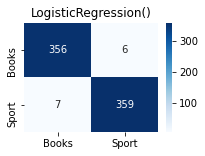

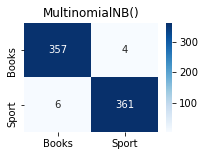

In [155]:
for model in [lr,nb]:
    classify(model, xtrain_cv1, ytrain1, xtest_cv1, ytest1, classes1)

From the above results we can see that Naive Bayes is performing well for this pair of category and there are no such large discrepancies in the results obtained from using TfidfVectorizer and CountVectorizer. From confusion matrix above we can see that Naive Bayes incorrectly classified 16 documents as 'Books' using TfidfVectorizer and 6 using CountVectorizer which is better. So CountVectorizer performed better for the first pair.

### Pair 2: (Music, Sport)

###### Using TfidfVectorizer

LogisticRegression()  Training accuracy:  0.995850622406639  Testing accuracy:  0.9682320441988951
MultinomialNB()  Training accuracy:  0.9986168741355463  Testing accuracy:  0.9737569060773481


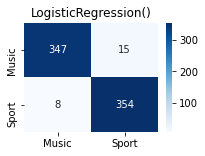

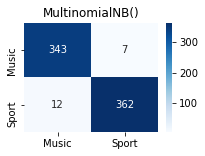

In [156]:
for model in [lr,nb]:
    classify(model, xtrain_tfidf2, ytrain2, xtest_tfidf2, ytest2, classes2)

###### Using CountVectorizer

LogisticRegression()  Training accuracy:  1.0  Testing accuracy:  0.9668508287292817
MultinomialNB()  Training accuracy:  0.9996542185338866  Testing accuracy:  0.9765193370165746


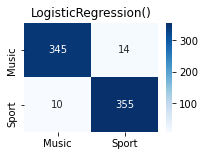

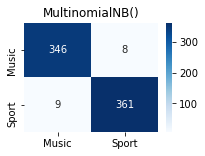

In [157]:
for model in [lr,nb]:
    classify(model, xtrain_cv2, ytrain2, xtest_cv2, ytest2, classes2)

From the above results we can see that Naive Bayes is performing well for this pair of category and there are no such large discrepancies in the results obtained from using TfidfVectorizer and CountVectorizer. From confusion matrix above we can see that Naive Bayes incorrectly classified 12 documents as 'Music' using TfidfVectorizer and 9 using CountVectorizer which is again better. So CountVectorizer performed better here.

### Pair 3: (Books, Music)

###### Using TfidfVectorizer

LogisticRegression()  Training accuracy:  0.9854872149274361  Testing accuracy:  0.9447513812154696
MultinomialNB()  Training accuracy:  0.9906703524533518  Testing accuracy:  0.9267955801104972


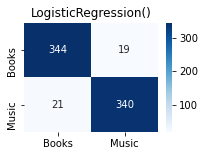

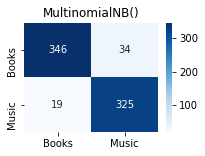

In [158]:
for model in [lr,nb]:
    classify(model, xtrain_tfidf3, ytrain3, xtest_tfidf3, ytest3, classes3)

###### Using CountVectorizer

LogisticRegression()  Training accuracy:  0.9996544574982723  Testing accuracy:  0.9392265193370166
MultinomialNB()  Training accuracy:  0.9920525224602627  Testing accuracy:  0.93646408839779


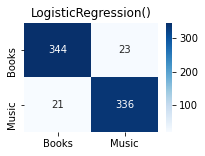

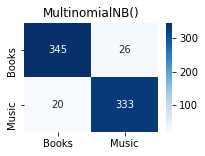

In [159]:
for model in [lr,nb]:
    classify(model, xtrain_cv3, ytrain3, xtest_cv3, ytest3, classes3)

From the above results we can see that Logistic Regression is performing well for this pair of category and there are no such large discrepancies in the results obtained from using TfidfVectorizer and CountVectorizer. From confusion matrix above we can see that Logistic Regression incorrectly classified 19 documents as 'Music' using TfidfVectorizer and 23 documents using CountVectorizer. So for this pair, TfidfVectorizer is giving better results.

#### Comparison of all the unique pairs
<br>Overall for Binary Classification, the best performance was given by Naive Bayes model for the pair **(Books, Sports)** with an testing accuracy of **98.6 %**. As the data is balance accuracy is the appropriate evaluation metric to use. It also gave the lowest misclassification rate of **0.02**. The lowest performance by Naive Bayes model was given for the pair **(Music, Books)** with a misclassification rate of **0.08** using TfidfVectorizer. There were no such large difference between the performance of all the models. All the models are giving testing accuracy which is less than and similar to the training accuracy so there is no issue of overfitting. To avoid peeking, the entire data set is divided into a training and testing split of 80% and 20% respectively. So, considering all this I can see that the models are generalizing well on unseen test data.

## Task 3 - Multiclass classification

In [160]:
xtrain, xtest, ytrain , ytest = model_selection.train_test_split(final['Document'],final['Category'], test_size = 0.2, 
                                                                 random_state=42)
print(' Train shape: ',xtrain.shape)
print(' Test shape: ',xtest.shape)

 Train shape:  (4349,)
 Test shape:  (1088,)


In [161]:
#Vectorize all the three pairs using both TfidfVectorizer and CountVectorizer
xtrain_tfidf, xtest_tfidf, xtrain_cv, xtest_cv = vectorization(xtrain, xtest)

#Encode all the three pairs
ytrain, ytest, classes = encode(ytrain, ytest)

###### Using TfidfVectorizer

MultinomialNB()  Training accuracy:  0.9891929179121637  Testing accuracy:  0.9310661764705882
SGDClassifier()  Training accuracy:  0.9993101862497126  Testing accuracy:  0.9292279411764706


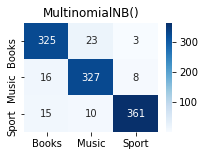

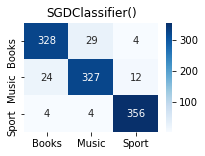

In [166]:
nb = MultinomialNB()
sgd = SGDClassifier(alpha=0.0001)

for model in [nb,sgd]:
    classify(model, xtrain_tfidf, ytrain, xtest_tfidf, ytest, classes)

#### Using CountVectorizer

MultinomialNB()  Training accuracy:  0.9928719245803633  Testing accuracy:  0.9393382352941176
SGDClassifier()  Training accuracy:  1.0  Testing accuracy:  0.9163602941176471


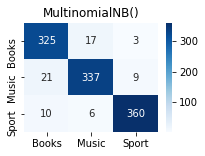

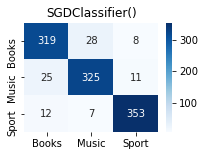

In [170]:
for model in [nb,sgd]:
    classify(model, xtrain_cv, ytrain, xtest_cv, ytest, classes)

From the above results we can see that for multiclass classification also the Naive Bayes model performed well. The best results were achieved by using CountVectorizer. The model actually failed to correctly classify 30 documents as 'Music' using CountVectorizer but using TfidfVectorizer it only failed to classify 24 documents as 'Music'. Again there were no such large discrepancies in the results seen for multiclass classfication. The learning rate that I have used for the SGDClassifier is 0.0001. It can be tuned further so the classifier might then perform better than the Naive Bayes. 

## Conclusion:
<br> The data was successfully collected from the provided link using BeautifulSoup and stored in a proper format in a dataframe. Required cleaning was performed during the data collection part like collecting and storing only the name of the category and removing string "Category: " from it. Once the data was collected, The title and snippet were combined into single corupus of documents. All the required data-preprocessing steps are taken and the data is cleaned before giving it to the models. For the binary classification, dataframes are created for each pair from the orginial dataframe. Appropriate training/testing splits are done to avoid data peeking and then two types of Vectorizers are used to convert the words into numerical format in order to feed the data to the models. Label encoding is applied on the target variables. Logistic Regression and Naive Bayes models are used for binary classification tasks and SGDClassifier for multiclass classification. Finally the models are trained their performance is evaluated on unseen test data.

## Future Scope:
<br> We can use Neural Networks to classifiy the documents when there is huge amount of the data available for training.
<br> Models like LSTM, CNN and BILSTM are proven to work best for text classification tasks.
<br> Hyperparameter tuning can be done using the GridSearchCV and RandomizedSearchCV to get the best combination of parameters suited for the given dataset.
<br> Vectorization methods can be improved by using pre-trained vectorizers like Word2Vec and GLOVE.